# Quantify Sampling Quality
The goal in this notebook is to determine the how well a certain trajectory samples all possible environments

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import optimize
import pickle as pkl
import pandas as pd
import numpy as np
import itertools
import gzip
import os

## Import the trajectories, sampling points, and sampling strategies
The bits of data used during the match

In [2]:
random_data = pd.read_pickle(os.path.join('..', 'data', 'random_data.pkl.gz'))

In [3]:
channel_data = pd.read_pickle(os.path.join('..', 'data', 'channel_data.pkl.gz'))

Load the points created by randomly sampling space

In [4]:
sampling_data = pd.read_pickle('sampled_space.pkl.gz')

Load in the projection learned from the sampling space

In [5]:
with gzip.open('manifold.pkl.gz', 'rb') as fp:
    manifold = pkl.load(fp)

Load the feature generator

In [6]:
with open(os.path.join('..', '..', 'featurizers.pkl'), 'rb') as fp:
    featurizers = pkl.load(fp)[:-1]

Load the list of features used to determine the mainfold

In [7]:
with open('manifold_features.pkl', 'rb') as fp:
    X_cols = pkl.load(fp)

Load in the simulation cell

In [8]:
with open(os.path.join('..', '..', 'al_starting_frame.pkl'), 'rb') as fp:
    simulation_cell = pkl.load(fp)

## Create tool for quantifying degree of sampling
We use an approach of finding what fraction of points in the sampling space we pass "near." 

In [9]:
sampling_proj = manifold.transform(sampling_data[X_cols])

Build a NN finding tool. (I don't normalize, because all the charge density features exist on the same range)

In [10]:
neighbors = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(sampling_proj)

Use 5% of the total variation in the manifold as a metric for distance

In [11]:
thr_dist = (sampling_proj.max() - sampling_proj.min()) * 0.05
print('Threshold distance: {:.2f}'.format(thr_dist))

Threshold distance: 1.32


Plot the random trajectory, to visualize our matching procedure

In [12]:
def get_near_points(dataset):
    """Find the points in the sampling distribution that a trajectory passes near
    
    Args:
        dataset (DataFrame): Sampling of space
    Returns:
        ([int]) Indicies of points in the sampling set the dataset is near
    """
    
    # Get the distances from each point
    dist, ind = neighbors.kneighbors(manifold.transform(dataset[X_cols]))
    
    # Get the indices where the trajectory passes within the threshold distance
    ind = ind[dist < thr_dist]
    
    return sorted(set(np.squeeze(ind).tolist()))

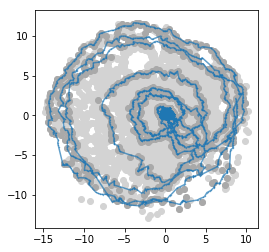

In [13]:
fig, ax = plt.subplots()

# Get the points the random trajectory passes near
hits = get_near_points(random_data)

# Get the projection of the random trajectory
random_proj = manifold.transform(random_data[X_cols])

ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7)

fig.set_size_inches(4, 4)

Measure the performance of the two trajectories

In [14]:
def score_sampling_performance(dataset):
    """Given a dataset, determine the fraction of points in the random sampling space it passes 'near'
    
    Args:
        dataset (DataFrame): Sampling of space
    Returns:
        float - Fraction of sampling space it passes 'near'"""
    
    return len(get_near_points(dataset)) / len(sampling_data)

In [15]:
print('Random trajectory score: {:.1f}%'.format(score_sampling_performance(random_data) * 100))

Random trajectory score: 22.0%


In [16]:
print('Channel trajectory score: {:.2f}%'.format(score_sampling_performance(channel_data) * 100))

Channel trajectory score: 0.42%


*Finding*: Yes, the random trajecotry seems to perform better. It samples >10x more of the space

## Can I find a better trajectory?
Only 20% of the search space is not particularly impressive. 

First, get the size of the current trajectory

In [17]:
traj_len = random_data['displacement'].max()
traj_time = len(random_data)
print('The trajectory is {:.1f} a_B and {} timesteps long'.format(
    traj_len, traj_time
))

The trajectory is 140.0 a_B and 9800 timesteps long


Make a function for optimizing the trajectory

In [18]:
def generate_trajectory(start_pos, direction, velocity, 
                       traj_len=traj_len, nsteps=traj_time):
    # Normalize the projectile direction
    norm_dir = np.divide(direction, np.linalg.norm(direction))
    
    # Make the new trajectory
    vel = norm_dir * velocity
    traj = np.array(start_pos) + np.dot(norm_dir[:, None],
                                        np.linspace(0, traj_len, nsteps)[None, :]).T
    
    # Turn it into a dataframe
    traj_data = pd.DataFrame(list(itertools.zip_longest(traj, [vel],
                                                       fillvalue=vel)),
                            columns=['position', 'velocity'])
    
    # Compute the features
    for f in featurizers:
        f.featurize_dataframe(traj_data, ['position', 'velocity'])
    
    return traj_data

In [19]:
def test_trajectory(start_pos, direction, velocity=1,
                    traj_len=traj_len, nsteps=traj_time):
    """Compute the score of a certain candidate trajecotry"""
    # Generate the trajectory
    traj_data = generate_trajectory(start_pos, direction,
                                   velocity, traj_len, nsteps)
        
    # Score the trajectory
    return score_sampling_performance(traj_data)

In [20]:
%%time
score = test_trajectory([0.1,0,0], [1,0,0])
print('Example score: {:.2f}%'.format(score * 100))

Example score: 1.23%
CPU times: user 15.5 s, sys: 9.66 s, total: 25.2 s
Wall time: 22.1 s


Optimize the trajectory. For now, I'm using a downhill simplex.

*Complaints*: Might want to switch to a global optimizer later

In [21]:
start = random_data.iloc[0]
x0 = np.hstack((start['position'], start['velocity']))
print('Initial:', x0)

Initial: [0.         5.74196597 5.74196597 0.232382   0.650984   0.722647  ]


In [22]:
%%time
res, fall = optimize.fmin(lambda x: -test_trajectory(x[:3], x[3:]), 
                          x0, maxiter=32, retall=True)

CPU times: user 24min 45s, sys: 14min 10s, total: 38min 55s
Wall time: 34min 32s


In [23]:
print('Optimized:', res)

Optimized: [1.02383091e-04 5.80295803e+00 5.62424148e+00 2.33118155e-01
 6.46989812e-01 7.38782082e-01]


In [24]:
opt_start, opt_direction = res[:3], res[3:]

In [25]:
score = test_trajectory(opt_start, opt_direction)
print('Optimized score: {:.2f}%'.format(score * 100))

Optimized score: 23.24%


Plot the increase in fitness over iterations

In [26]:
scores = [test_trajectory(x[:3], x[3:]) for x in fall+[res]]

Text(0,0.5,'Score')

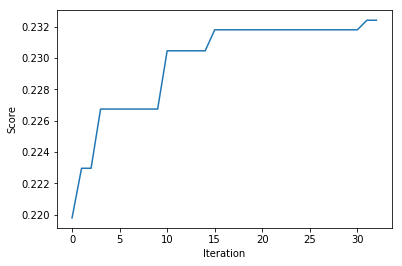

In [27]:
fig, ax = plt.subplots()

ax.plot(range(len(fall)+1), scores)

ax.set_xlabel('Iteration')
ax.set_ylabel('Score')

Plot the trajectory over time, to see if the optimization is better

In [28]:
steps = np.linspace(0, 1, 10+1)

In [29]:
%%time
random_over_time = [0] + [test_trajectory(start['position'], start['velocity'],
                                          traj_len=traj_len*x, 
                                          nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 2min 17s, sys: 1min 14s, total: 3min 31s
Wall time: 2min 42s


In [30]:
%%time
opt_over_time = [0] + [test_trajectory(opt_start, opt_direction,
                                       traj_len=traj_len*x,
                                       nsteps=int(traj_time * x)) 
                          for x in steps[1:]]

CPU times: user 2min 15s, sys: 1min 11s, total: 3min 27s
Wall time: 2min 39s


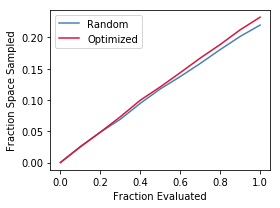

In [31]:
fig, ax = plt.subplots()

ax.plot(steps, random_over_time, color='steelblue', label='Random')
ax.plot(steps, opt_over_time, color='crimson', label='Optimized')

ax.set_xlabel('Fraction Evaluated')
ax.set_ylabel('Fraction Space Sampled')

ax.legend()

fig.set_size_inches(4, 3)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'sampling-comparison.png'), dpi=320)

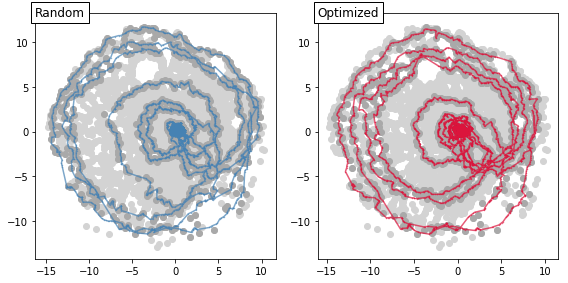

In [32]:
fig, axs = plt.subplots(1, 2)

# Generate the optimized trajectory
opt_data = generate_trajectory(opt_start, opt_direction, 1)

for ax, traj, c, l in zip(axs, [random_data, opt_data],
                      ['steelblue', 'crimson'],
                      ['Random', 'Optimized']):
    # Get the points the random trajectory and passes near
    hits = get_near_points(traj)

    # Get the projection of the random trajectory
    random_proj = manifold.transform(traj[X_cols])

    # Plot the trajectory
    ax.scatter(sampling_proj[:, 0], sampling_proj[:, 1], c='lightgray')
    ax.scatter(sampling_proj[hits, 0], sampling_proj[hits, 1],
          c='darkgrey')

    ax.plot(random_proj[:, 0], random_proj[:, 1], '.-', ms=0.8, alpha=0.7,
           color=c)
    
    # Label it
    ax.text(0, 1, l, va='center', transform=ax.transAxes,
            fontsize=12, bbox={'facecolor': 'w', 'edgecolor': 'k'})
    
fig.set_size_inches(8, 4)
fig.tight_layout()
fig.savefig(os.path.join('figures', 'traj_comparison.png'), dpi=320)

*Ideas*: 
- Global optimization
- Multiple trajectories
- Penalty for close passes to atoms